# General processing of flight data

In [ ]:
from aux.gpx_read import *
from aux.imu_read import *
from aux.lidar_read import *
from aux.navsat_read import *
from aux.px4_read import *
from aux.rosbag_aux import *
from aux.srr308_read import *

import datetime

test_num = 0
test_names = ['6m_1', '6m_2', '50m_1', '50m_2', '80m_1', '80m_2']
name = test_names[test_num]
folder_path = 'data/' + name
db3_reader = get_db3_reader(folder_path, 'ROSBAG*')
db3_px4_reader = get_db3_reader(folder_path, 'sensor_bag*')

# create all data frames to find the first timestamp to reference every other DF to
radar_df = get_srr308_pointcloud_df_from_db3_reader(db3_reader)
lidar_df = get_lidar_df_from_db3_reader(db3_reader)
vel_df = get_velocity_df_from_db3_reader(db3_reader)
baro_df = get_baro_df_from_db3_reader(db3_px4_reader)

df_list = [radar_df, lidar_df, vel_df, baro_df]
first_timestamp = radar_df['timestamp_sample'][0]
for df in df_list:
    first_timestamp = min(first_timestamp, df['timestamp_sample'][0])

print("First time stamp:", datetime.datetime.fromtimestamp(first_timestamp).isoformat())

Found ROS 2 bag: data/50m_2/ROSBAG_2025-04-28_16-05-52.540/ROSBAG_2025-04-28_16-05-52.540_0.db3
Found ROS 2 bag: data/50m_2/sensor_bag_20250428_160551/sensor_bag_20250428_160551_0.db3


[INFO] [1746506687.617569611] [rosbag2_storage]: Opened database 'data/50m_2/ROSBAG_2025-04-28_16-05-52.540/ROSBAG_2025-04-28_16-05-52.540_0.db3' for READ_ONLY.
[INFO] [1746506687.882135834] [rosbag2_storage]: Opened database 'data/50m_2/sensor_bag_20250428_160551/sensor_bag_20250428_160551_0.db3' for READ_ONLY.


First time stamp: 2025-04-28T16:05:52.538712


In [35]:
radius = 3 ## Read lidar and radar, generate altitude measurement
lidar_altitude = get_altitude_from_lidar_pc(lidar_df['np_points'], (0,0), radius)
radar_altitude = get_altitude_from_radar_pc(radar_df['points'], 0, radius)
radar_flight_seconds = [radar_df['timestamp_sample'][i]-first_timestamp for i in range(radar_df.shape[0])]
lidar_flight_seconds = [lidar_df['timestamp_sample'][i]-first_timestamp for i in range(lidar_df.shape[0])]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


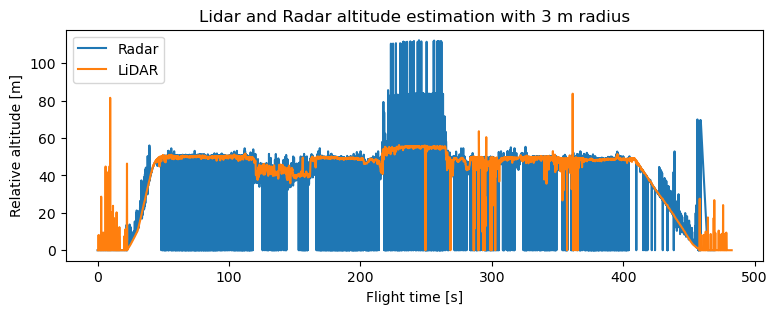

In [36]:
plt.figure(figsize=(9, 3))
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['savefig.dpi'] = 300
plt.plot(radar_flight_seconds, radar_altitude, label='Radar')
plt.plot(lidar_flight_seconds, lidar_altitude, label='LiDAR')
plt.title("Lidar and Radar altitude estimation with 3 m radius")
plt.xlabel("Flight time [s]")
plt.ylabel("Relative altitude [m]")
plt.legend(loc="upper left")
# plt.savefig('figures/'+name+'_full_radar_lidar.png', format='png', bbox_inches='tight')
plt.savefig('figures/'+name+'_full_radar_lidar.eps', format='eps', bbox_inches='tight')
plt.show()

### Where and when do the static parts of the experiment take place?

In [37]:
def get_segment_index_from_ts_segments(sensor_df, reference_ts_segments):
    sensor_segments = []
    m = 0   # to comare to
    _s = -1
    _e = -1
    for i in range(sensor_df.shape[0]):
        if (m < len(reference_ts_segments)):
            ts_seg = reference_ts_segments[m]
            ts = sensor_df['timestamp_sample'][i]
            if (ts >= ts_seg[0] and _s == -1):  # first time current ts is above the lower limit
                _s = i
            if (ts <= ts_seg[1]):
                _e = i
            if (ts > ts_seg[1]):
                if (_e > _s):
                    sensor_segments.append([_s, _e])
                _s, _e = -1, -1
                m += 1
    if (_s != -1): # segment initialized but not finalized
        sensor_segments.append([_s, sensor_df.shape[0]-1])
    return sensor_segments

def get_sensor_flight_seconds(sensor_df, first_ts):
    return [sensor_df['timestamp_sample'][i]-first_ts for i in range(sensor_df.shape[0])]

In [38]:
low_limit = 0.3     # m/s
min_duration = 8    # in seconds
max_duration = 20   # in seconds
if name == '6m_1': low_limit, min_duration, max_duration = 0.2, 7, 20  #  6m1
elif name == '6m_2': low_limit, min_duration, max_duration = 0.3, 8, 20  #  6m2
elif name == '50m_1': low_limit, min_duration, max_duration = 0.2, 7, 15  # 50m1
elif name == '50m_2': low_limit, min_duration, max_duration = 0.3, 5, 20  # 50m2
elif name == '80m_1': low_limit, min_duration, max_duration = 0.3, 5, 20  # 80m1
elif name == '80m_2': low_limit, min_duration, max_duration = 0.3, 7, 20  # 80m2
else:
    print("Qué estás haciendo Camilo?")

speed = get_speed_from_navsat_velocity_df(vel_df)

_ts_s, _ts_e = 0, 0
_s = 0

reference_timestamp_segments = []

speed_segments = []
for i in range(speed.shape[0]):
    if (speed[i] < low_limit and _ts_s == 0):  # first ts with low speed
        _ts_s = vel_df['timestamp_sample'][i]
        _s = i
    if (speed[i] > low_limit and _ts_s != 0):  # over speed threshold, already have a starting point
        _ts_e = vel_df['timestamp_sample'][i-1]
        duration = _ts_e - _ts_s
        if (duration >= min_duration and duration < max_duration):
            reference_timestamp_segments.append([_ts_s, _ts_e])
            speed_segments.append([_s, i])
        _ts_s, _ts_e = 0, 0


## show where we are in these segments | second try
navsat_df = get_navsat_df_from_db3_reader(db3_reader)
navsat_segments = get_segment_index_from_ts_segments(navsat_df, reference_timestamp_segments)

print("Segments found:", len(navsat_segments))
for i in range(len(navsat_segments)): #segment in navsat_segments:
    print("Length segment", i, "in seconds:", navsat_df['timestamp_sample'][navsat_segments[i][1]]-navsat_df['timestamp_sample'][navsat_segments[i][0]])

## same as with position, based on speed timestamps, but with radar
radar_segments = get_segment_index_from_ts_segments(radar_df, reference_timestamp_segments)
lidar_segments = get_segment_index_from_ts_segments(lidar_df, reference_timestamp_segments)

print("Number of radar segments found:", len(radar_segments))
for i in range(len(radar_segments)): #segment in radar_segments:
    print("Length segment", i, "in seconds:", radar_df['timestamp_sample'][radar_segments[i][1]]-radar_df['timestamp_sample'][radar_segments[i][0]])

print("Number of lidar segments found:", len(lidar_segments))
for i in range(len(lidar_segments)): #segment in radar_segments:
    print("Length segment", i, "in seconds:", lidar_df['timestamp_sample'][lidar_segments[i][1]]-lidar_df['timestamp_sample'][lidar_segments[i][0]])

baro_segments = get_segment_index_from_ts_segments(baro_df, reference_timestamp_segments)

Segments found: 7
Length segment 0 in seconds: 12.388039588928223
Length segment 1 in seconds: 11.805672883987427
Length segment 2 in seconds: 14.00784707069397
Length segment 3 in seconds: 13.174469709396362
Length segment 4 in seconds: 15.17835545539856
Length segment 5 in seconds: 13.792289733886719
Length segment 6 in seconds: 5.997291088104248
Number of radar segments found: 7
Length segment 0 in seconds: 12.563281536102295
Length segment 1 in seconds: 11.963778257369995
Length segment 2 in seconds: 14.16559910774231
Length segment 3 in seconds: 13.364826679229736
Length segment 4 in seconds: 15.366207838058472
Length segment 5 in seconds: 13.964646100997925
Length segment 6 in seconds: 6.203895092010498
Number of lidar segments found: 7
Length segment 0 in seconds: 12.48331880569458
Length segment 1 in seconds: 11.717762231826782
Length segment 2 in seconds: 14.003258466720581
Length segment 3 in seconds: 13.244400024414062
Length segment 4 in seconds: 15.37227487564087
Length se

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


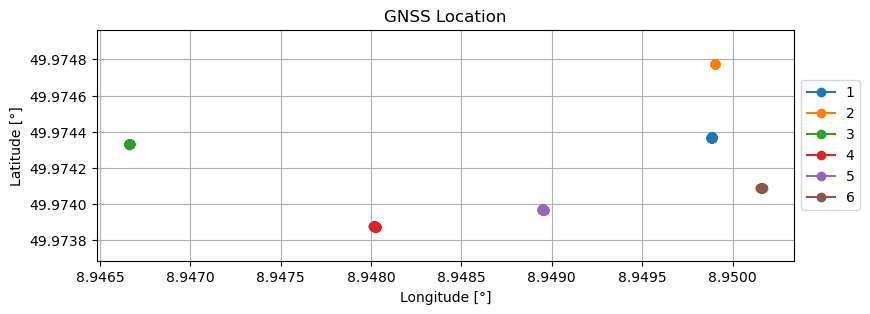

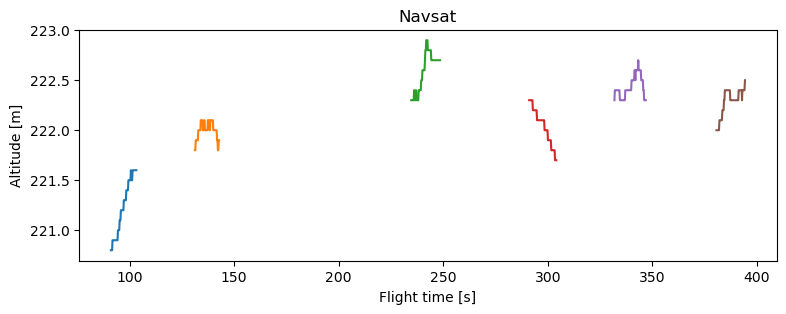

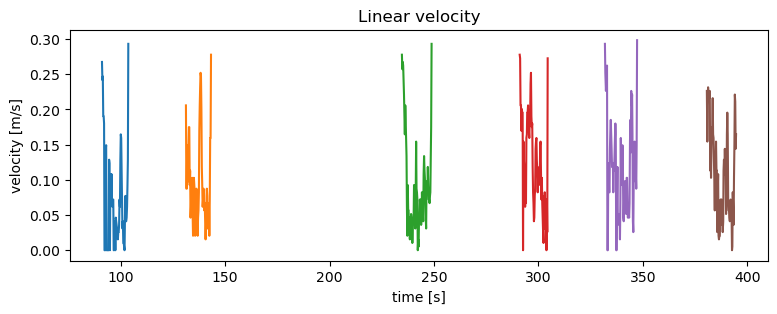

In [39]:
import matplotlib.ticker as ticker

# import contextily as ctx

navsat_short = navsat_df[navsat_segments[0][0]:navsat_segments[0][1]]


if (name == '80m_2'):
    first = 3
    navsat_segments = navsat_segments[first:first+6]
    speed_segments = speed_segments[first:first+6]
    radar_segments = radar_segments[first:first+6]
    lidar_segments = lidar_segments[first:first+6]
    baro_segments = baro_segments[first:first+6]
else:
    navsat_segments = navsat_segments[:6]
    speed_segments = speed_segments[:6]
    radar_segments = radar_segments[:6]
    lidar_segments = lidar_segments[:6]
    baro_segments = baro_segments[:6]

plt.figure(figsize=(9, 3))
for i in range(len(navsat_segments)):
    plt.plot(navsat_df['longitude'][navsat_segments[i][0]:navsat_segments[i][1]],
                navsat_df['latitude'][navsat_segments[i][0]:navsat_segments[i][1]],
                marker='o', linestyle='-', label=str(i+1))
# plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.4f'))  # For fixed decimals
# plt.ticklabel_format(useOffset=False)  # Disables offset
plt.gca().xaxis.get_major_formatter().set_useOffset(False)
plt.gca().yaxis.get_major_formatter().set_useOffset(False)
plt.title("GNSS Location")
plt.xlabel("Longitude [°]")
plt.ylabel("Latitude [°]")
# plt.legend(loc="upper left")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Outside right
plt.grid(True)
plt.axis('equal')
plt.savefig('figures/'+name+'_navsat_isolated_location.eps', format='eps', bbox_inches='tight')

flight_seconds = [navsat_df['timestamp_sample'][i]-first_timestamp for i in range(navsat_df.shape[0])]
plt.figure(figsize=(9, 3))
for segment in navsat_segments:
    # plt.plot(navsat_df['timestamp_sample'][segment[0]:segment[1]], navsat_df['altitude'][segment[0]:segment[1]], marker='o', linestyle='-')
    plt.plot(flight_seconds[segment[0]:segment[1]], navsat_df['altitude'][segment[0]:segment[1]], linestyle='-')
plt.title("Navsat")
plt.xlabel("Flight time [s]")
plt.ylabel("Altitude [m]")
plt.savefig('figures/'+name+'_navsat_altitude_segmented.eps', format='eps', bbox_inches='tight')

flight_seconds = [vel_df['timestamp_sample'][i]-first_timestamp for i in range(vel_df.shape[0])]
plt.figure(figsize=(9, 3))
for segment in speed_segments:
    plt.plot(flight_seconds[segment[0]:segment[1]], speed[segment[0]:segment[1]], linestyle='-')
plt.title("Linear velocity")
plt.xlabel("time [s]")
plt.ylabel("velocity [m/s]")
plt.savefig('figures/'+name+'_linear_velocity_segmented.eps', format='eps', bbox_inches='tight')


Well keep the first 6 segments

Now, what does the signal actually looks like in each scenario?

In [40]:
# ## same as with position, based on speed timestamps, but with radar
# radar_segments = get_segment_index_from_ts_segments(radar_df, reference_timestamp_segments)
# lidar_segments = get_segment_index_from_ts_segments(lidar_df, reference_timestamp_segments)

# print("Number of radar segments found:", len(radar_segments))
# for i in range(len(radar_segments)): #segment in radar_segments:
#     print("Length segment", i, "in seconds:", radar_df['timestamp_sample'][radar_segments[i][1]]-radar_df['timestamp_sample'][radar_segments[i][0]])

# print("Number of lidar segments found:", len(lidar_segments))
# for i in range(len(lidar_segments)): #segment in radar_segments:
#     print("Length segment", i, "in seconds:", lidar_df['timestamp_sample'][lidar_segments[i][1]]-lidar_df['timestamp_sample'][lidar_segments[i][0]])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


0 50.64857645237699
1 45.873376483008975
2 55.872148746397436
3 60.522796630859375
4 53.03577423095703
5 49.16492510901557


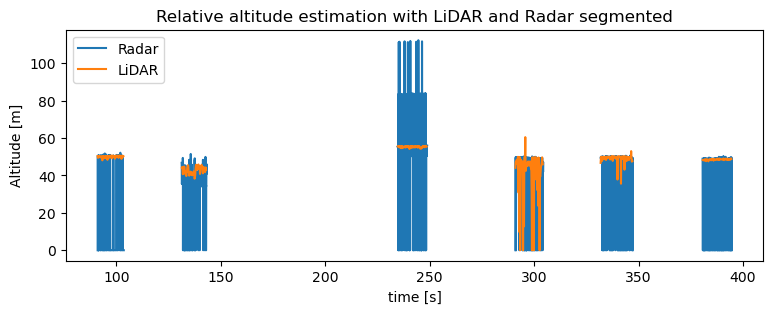

In [41]:
plt.figure(figsize=(9, 3))

radar_flight_seconds = [radar_df['timestamp_sample'][i]-first_timestamp for i in range(radar_df.shape[0])]
lidar_flight_seconds = [lidar_df['timestamp_sample'][i]-first_timestamp for i in range(lidar_df.shape[0])]

s = 0
plt.plot(radar_flight_seconds[radar_segments[s][0]:radar_segments[s][1]], radar_altitude[radar_segments[s][0]:radar_segments[s][1]],
                                  linestyle='-', color="tab:blue", label="Radar")
for s in range(1, len(radar_segments)):
    plt.plot(radar_flight_seconds[radar_segments[s][0]:radar_segments[s][1]], radar_altitude[radar_segments[s][0]:radar_segments[s][1]],
                                  linestyle='-', color="tab:blue")

# for segment in radar_segments:
#     plt.plot(radar_flight_seconds[segment[0]:segment[1]], radar_altitude[segment[0]:segment[1]], linestyle='-', color="tab:blue", label="radar")
s = 0

plt.plot(lidar_flight_seconds[lidar_segments[s][0]:lidar_segments[s][1]], lidar_altitude[lidar_segments[s][0]:lidar_segments[s][1]],
                                  linestyle='-', color="tab:orange", label="LiDAR")
print(s, np.max(lidar_altitude[lidar_segments[s][0]:lidar_segments[s][1]]))
for s in range(1, len(lidar_segments)):
    plt.plot(lidar_flight_seconds[lidar_segments[s][0]:lidar_segments[s][1]], lidar_altitude[lidar_segments[s][0]:lidar_segments[s][1]],
                                  linestyle='-', color="tab:orange")
    print(s, np.max(lidar_altitude[lidar_segments[s][0]:lidar_segments[s][1]]))

plt.title("Relative altitude estimation with LiDAR and Radar segmented")
plt.xlabel("time [s]")
plt.ylabel("Altitude [m]")
plt.legend(loc="upper left")
plt.savefig('figures/'+name+'_lidar_radar_segmented.eps', format='eps', bbox_inches='tight')
plt.show()


# Acá passa la magia, se guarda el csv
Vamos a ver la senial por escenario

In [42]:
navsat_flight_seconds = get_sensor_flight_seconds(navsat_df, first_timestamp)
baro_flight_seconds = get_sensor_flight_seconds(baro_df, first_timestamp)

g = 9.80665     # [m/s^2] acceleration of gravity
if name == '6m_1':    rho0 = 1.1992
elif name == '6m_2':  rho0 = 1.182862
elif name == '50m_1': rho0 = 1.194631
elif name == '50m_2': rho0 = 1.183264
elif name == '80m_1': rho0 = 1.195692
elif name == '80m_2': rho0 = 1.169429
else:
    print("Qué estás haciendo Camilo?")

rho0 = 1  # [kg/m^3] mass density at take-off | https://www.omnicalculator.com/physics/air-density 20°C 34% 101063 Pa before take off
p0 = baro_df['pressure'][0]     # [Pa = kg/ms^2] air pressure at starting point

H = p0/(rho0*g)
baro_altitude = np.log(p0/baro_df['pressure'])*H + 174

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


looking at higher altitude tests 6


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


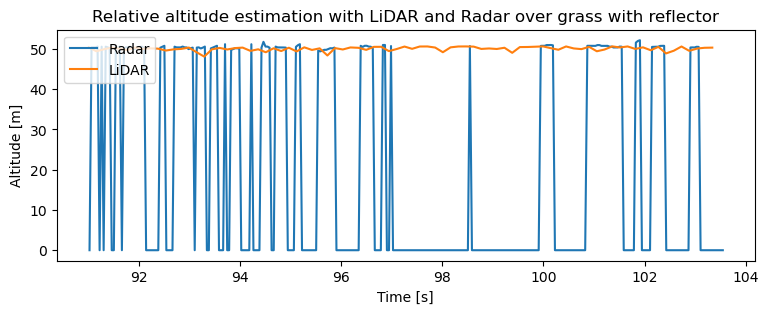

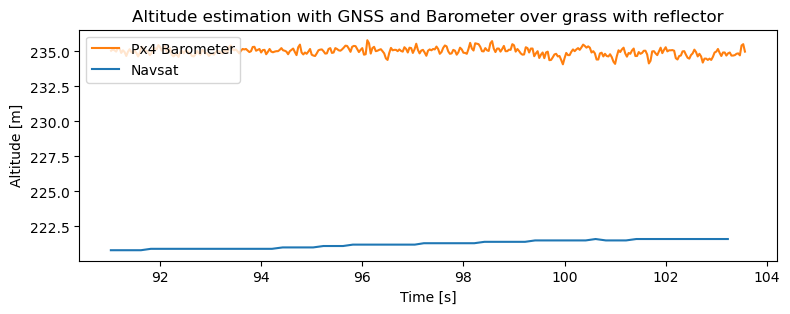

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


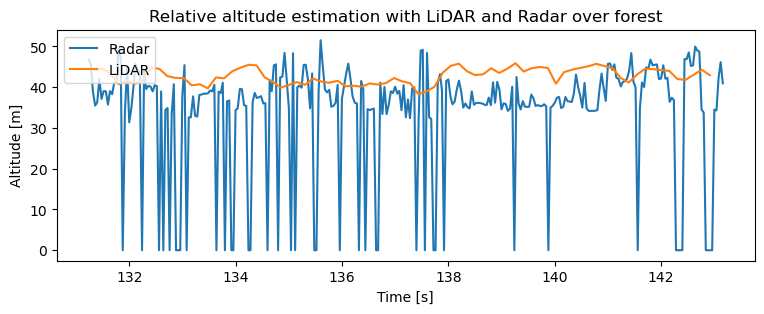

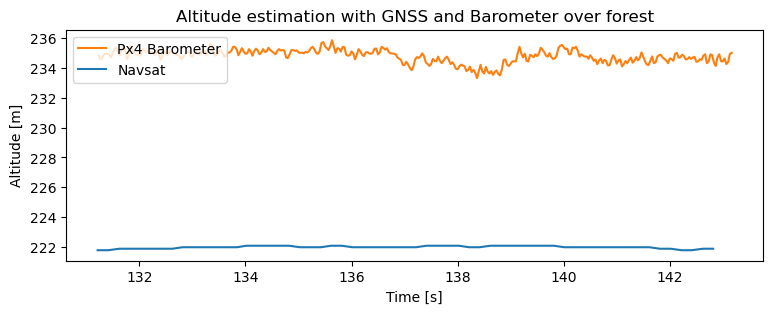

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


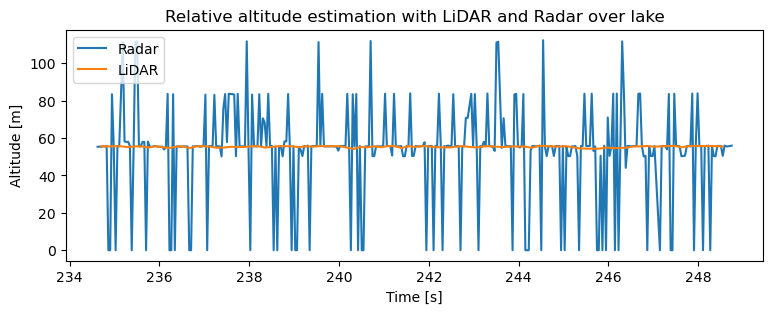

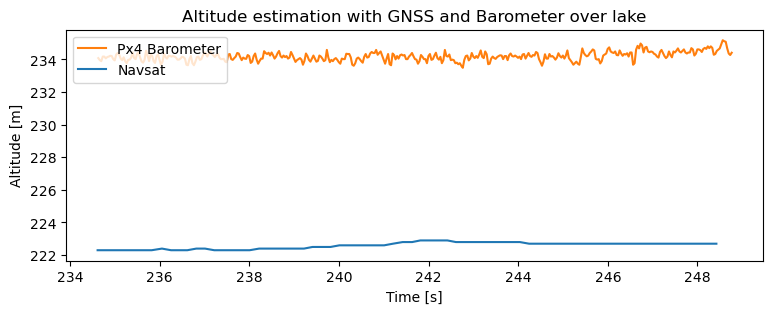

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


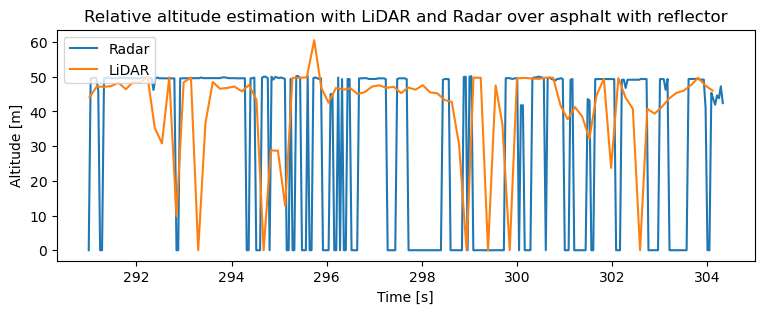

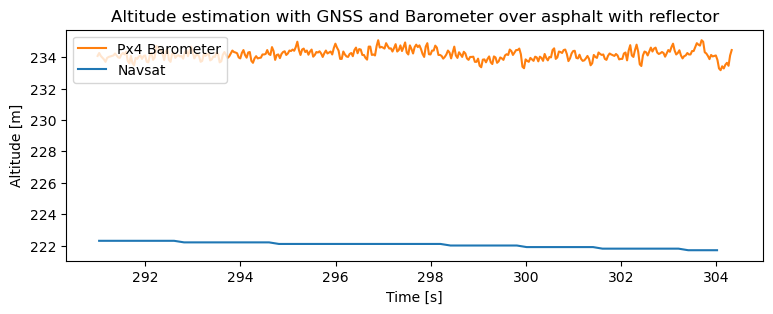

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


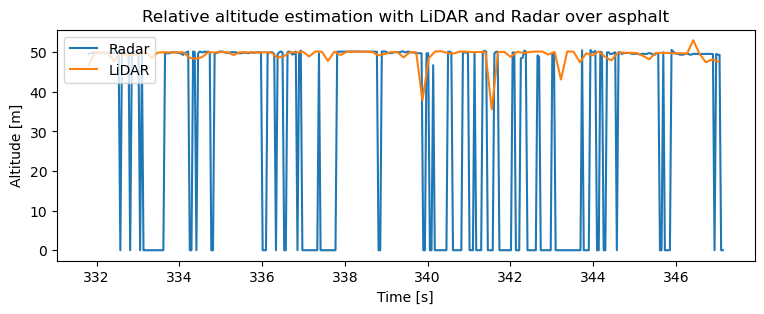

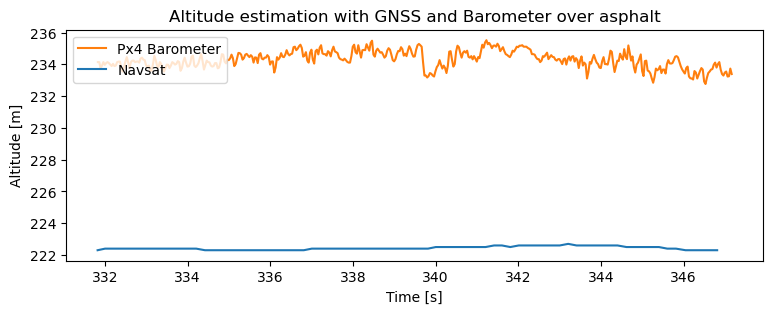

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


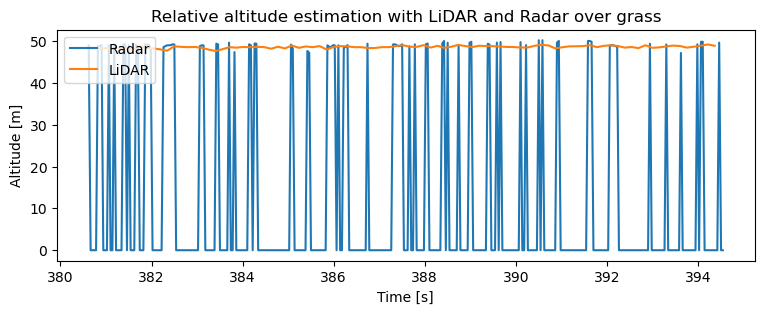

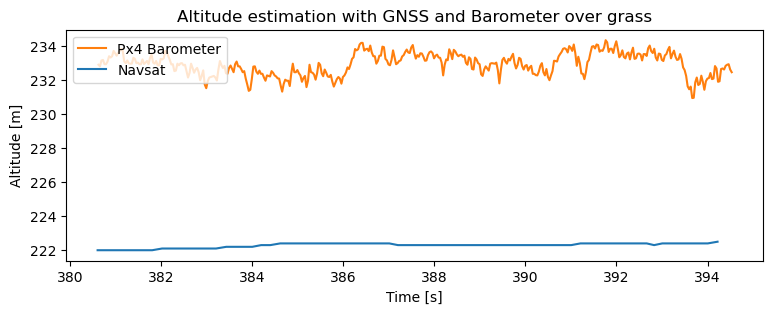

In [43]:
import csv

six = 0
scenarios = []
if len(speed_segments) > 3:
    print("looking at higher altitude tests", len(speed_segments))
    six = True
    scenarios = ['grass with reflector', 'forest', 'lake', 'asphalt with reflector', 'asphalt', 'grass']
else:
    print("is this 6m?", len(speed_segments))
    six = False
    scenarios = ['grass with reflector', 'asphalt with reflector', 'grass']

lidar_data = {}
for k in range(len(scenarios)):
    lidar_data[scenarios[k]] = lidar_altitude[lidar_segments[k][0]:lidar_segments[k][1]]

radar_data = {}
for k in range(len(scenarios)):
    radar_data[scenarios[k]] = radar_altitude[radar_segments[k][0]:radar_segments[k][1]]

baro_data = {}
for k in range(len(scenarios)):
    baro_data[scenarios[k]] = baro_altitude[baro_segments[k][0]:baro_segments[k][1]]

gnss_alti_data = {}
for k in range(len(scenarios)):
    gnss_alti_data[scenarios[k]] = navsat_df['altitude'][navsat_segments[k][0]:navsat_segments[k][1]]

csv_file_name = 'csv/lidar_radar_stats_'+name+'.csv'
fieldnames = ['scenario', 'radar_mean', 'radar_std',
                'radar_nz_mean', 'radar_nz_std',
                'lidar_mean', 'lidar_std',
                'lidar_nz_mean', 'lidar_nz_std',
                'baro_mean', 'baro_std',
                'gnss_mean', 'gnss_std',]

with open(csv_file_name, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()

    for s in range(len(scenarios)):

        lidar_data_nz = [x for x in lidar_data[scenarios[s]] if x > 0]
        radar_data_nz = [x for x in radar_data[scenarios[s]] if x > 0]

        lidar_mean = np.mean(lidar_data[scenarios[s]])
        lidar_nz_mean = np.mean(lidar_data_nz)
        radar_mean = np.mean(radar_data[scenarios[s]])
        radar_nz_mean = np.mean(radar_data_nz)

        lidar_std = np.std(lidar_data[scenarios[s]])
        lidar_nz_std = np.std(lidar_data_nz)
        radar_std = np.std(radar_data[scenarios[s]])
        radar_nz_std = np.std(radar_data_nz)

        baro_mean = np.mean(baro_data[scenarios[s]])
        baro_std = np.std(baro_data[scenarios[s]])

        gnss_alti_mean = np.mean(gnss_alti_data[scenarios[s]])
        gnss_alti_std = np.std(gnss_alti_data[scenarios[s]])

        writer.writerow({'scenario': scenarios[s],
                         'radar_mean': radar_mean,
                         'radar_std': radar_std,
                         'radar_nz_mean': radar_nz_mean,
                         'radar_nz_std': radar_nz_std,
                         'lidar_mean': lidar_mean,
                         'lidar_std': lidar_std,
                         'lidar_nz_mean': lidar_nz_mean,
                         'lidar_nz_std': lidar_nz_std,
                         'baro_mean': baro_mean, 
                         'baro_std': baro_std,
                         'gnss_mean': gnss_alti_mean,
                         'gnss_std': gnss_alti_std,
                         })

        plt.figure(figsize=(9, 3))
        plt.plot(radar_flight_seconds[radar_segments[s][0]:radar_segments[s][1]], radar_data[scenarios[s]],linestyle='-', color="tab:blue", label="Radar")
        plt.plot(lidar_flight_seconds[lidar_segments[s][0]:lidar_segments[s][1]], lidar_data[scenarios[s]],linestyle='-', color="tab:orange", label="LiDAR")
        plt.title("Relative altitude estimation with LiDAR and Radar over "+scenarios[s])
        plt.xlabel("Time [s]")
        plt.ylabel("Altitude [m]")
        plt.legend(loc="upper left")
        plt.savefig('figures/'+name+'_lr_'+scenarios[s]+'.eps', format='eps', bbox_inches='tight')

        plt.figure(figsize=(9, 3))
        plt.plot(baro_flight_seconds[baro_segments[s][0]:baro_segments[s][1]], baro_data[scenarios[s]], linestyle='-', color="tab:orange", label="Px4 Barometer")
        plt.plot(navsat_flight_seconds[navsat_segments[s][0]:navsat_segments[s][1]], gnss_alti_data[scenarios[s]], linestyle='-', color="tab:blue", label="Navsat")
        plt.title("Altitude estimation with GNSS and Barometer over "+scenarios[s])
        plt.xlabel("Time [s]")
        plt.ylabel("Altitude [m]")
        plt.legend(loc="upper left")
        plt.savefig('figures/'+name+'_baro_gnss_'+scenarios[s]+'.eps', format='eps', bbox_inches='tight')
        plt.show()

        plt.show()

# Datos de barómetro

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


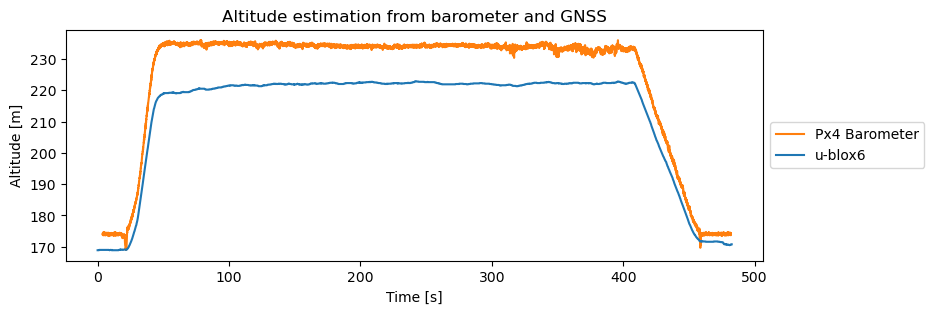

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Pressure at starting point 50m_2 : 100926.2109375


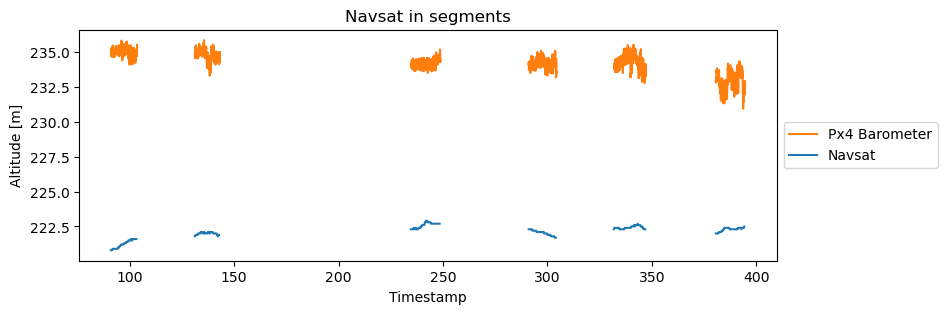

In [44]:
# navsat_flight_seconds = get_sensor_flight_seconds(navsat_df, first_timestamp)
# baro_flight_seconds = get_sensor_flight_seconds(baro_df, first_timestamp)

# g = 9.80665     # [m/s^2] acceleration of gravity

# # low_limit = 0.3     # m/s
# # min_duration = 8    # in seconds
# # max_duration = 20   # in seconds
# if name == '6m_1':    rho0 = 1.1992
# elif name == '6m_2':  rho0 = 1.182862
# elif name == '50m_1': rho0 = 1.194631
# elif name == '50m_2': rho0 = 1.183264
# elif name == '80m_1': rho0 = 1.195692
# elif name == '80m_2': rho0 = 1.169429
# else:
#     print("Qué estás haciendo Camilo?")

rho0 = 1  # [kg/m^3] mass density at take-off | https://www.omnicalculator.com/physics/air-density 20°C 34% 101063 Pa before take off
p0 = baro_df['pressure'][0]     # [Pa = kg/ms^2] air pressure at starting point

# p0 = 100926.2109375 # for 50m2
H = p0/(rho0*g)
baro_altitude = np.log(p0/baro_df['pressure'])*H + 174

plt.figure(figsize=(9, 3))
plt.plot(baro_flight_seconds, baro_altitude, linestyle='-', color="tab:orange", label="Px4 Barometer")
plt.plot(navsat_flight_seconds, navsat_df['altitude'], linestyle='-', color="tab:blue", label="u-blox6")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Outside right
plt.title("Altitude estimation from barometer and GNSS")
plt.xlabel("Time [s]")
plt.ylabel("Altitude [m]")
plt.savefig('figures/'+name+'_barometer_GNSS.eps', format='eps', bbox_inches='tight')
plt.show()

plt.figure(figsize=(9, 3))

_x = []
_y = []
s = 0
plt.plot(baro_flight_seconds[baro_segments[s][0]:baro_segments[s][1]], baro_altitude[baro_segments[s][0]:baro_segments[s][1]],
             linestyle='-', color="tab:orange", label="Px4 Barometer")
for s in range(1, len(baro_segments)):
    plt.plot(baro_flight_seconds[baro_segments[s][0]:baro_segments[s][1]], baro_altitude[baro_segments[s][0]:baro_segments[s][1]],
             linestyle='-', color="tab:orange")

s=0
plt.plot(navsat_flight_seconds[navsat_segments[s][0]:navsat_segments[s][1]], navsat_df['altitude'][navsat_segments[s][0]:navsat_segments[s][1]],
             linestyle='-', color="tab:blue", label="Navsat")
for s in range(1, len(navsat_segments)):
    plt.plot(navsat_flight_seconds[navsat_segments[s][0]:navsat_segments[s][1]], navsat_df['altitude'][navsat_segments[s][0]:navsat_segments[s][1]],
             linestyle='-', color="tab:blue")

# plt.legend(loc="upper left")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Outside right

plt.title("Navsat in segments")
plt.xlabel("Timestamp")
plt.ylabel("Altitude [m]")
plt.savefig('figures/'+name+'_barometer_GNSS_segmented.eps', format='eps', bbox_inches='tight')
print("Pressure at starting point " + name +" :", baro_df['pressure'][0])

100926.2109375

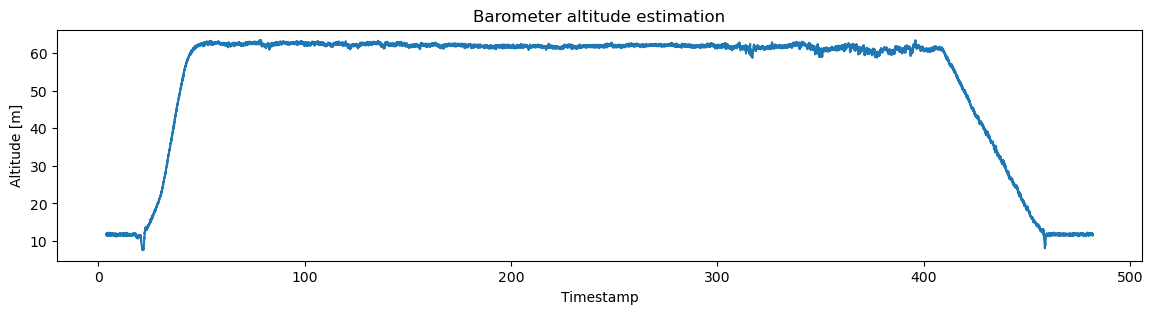

In [45]:
## get segments for barometer
baro_segments = get_segment_index_from_ts_segments(baro_df, reference_timestamp_segments)
baro_flight_seconds = get_sensor_flight_seconds(baro_df, first_timestamp)

g = 9.80665     # [m/s^2] acceleration of gravity
rho0 = 1.2250   # [kg/m^3] mass density of air at sea level
rho0 = 1.19743  # [kg/m^3] mass density at take-off | https://www.omnicalculator.com/physics/air-density 20°C 34% 101063 Pa before take off
# p0 = 101325     # [Pa = kg/ms^2] air pressure at sea level in Pa
p0 = 101063     # [Pa = kg/ms^2] air pressure at starting point

H = p0/(rho0*g)
baro_altitude = np.log(p0/baro_df['pressure'])*H

plt.figure(figsize=(14, 3))
plt.plot(baro_flight_seconds, baro_altitude, linestyle='-', color="tab:blue", label="Px4 Barometer")
plt.title("Barometer altitude estimation")
plt.xlabel("Timestamp")
plt.ylabel("Altitude [m]")
baro_df['pressure'][0]

1745849158.585436 0.17897915840148926


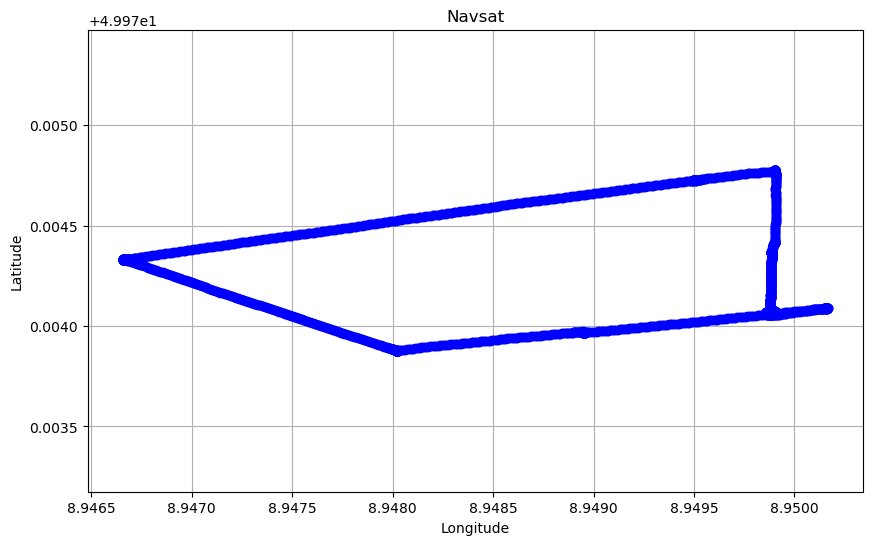

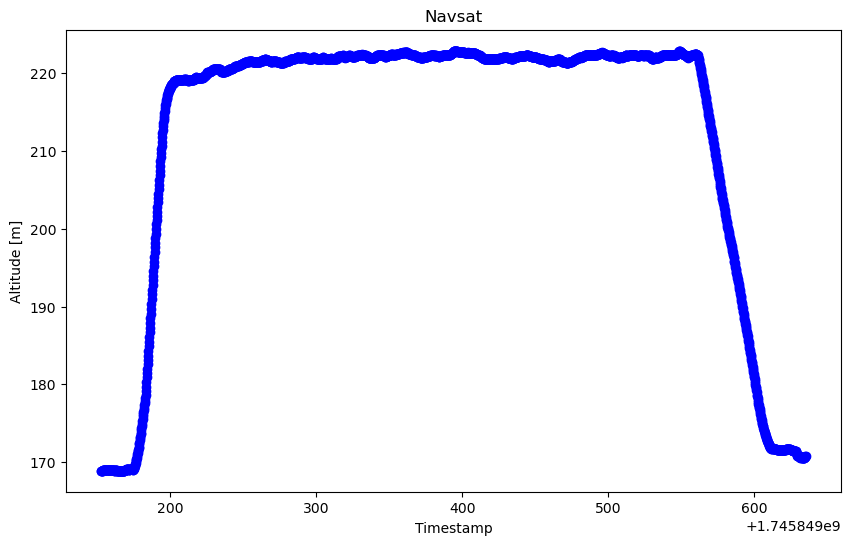

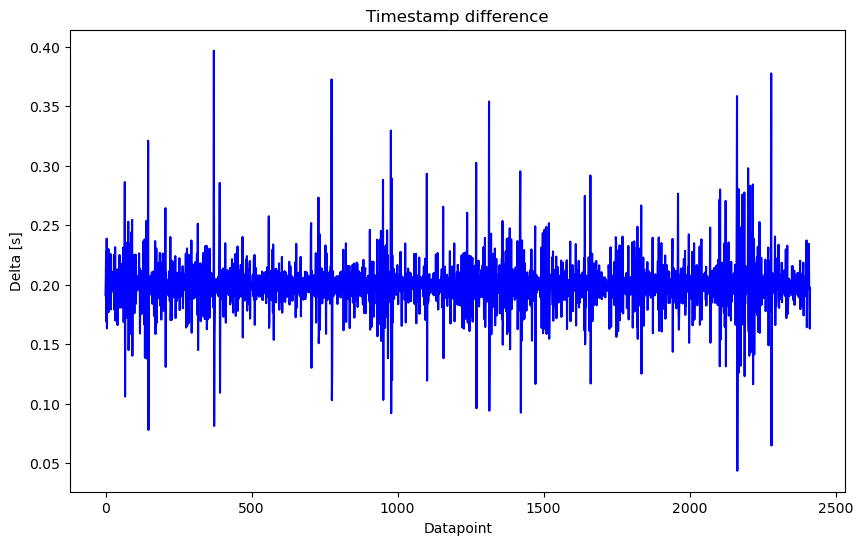

In [46]:
navsat_df = get_navsat_df_from_db3_reader(db3_reader)
plot_navsat_data_from_df(navsat_df)

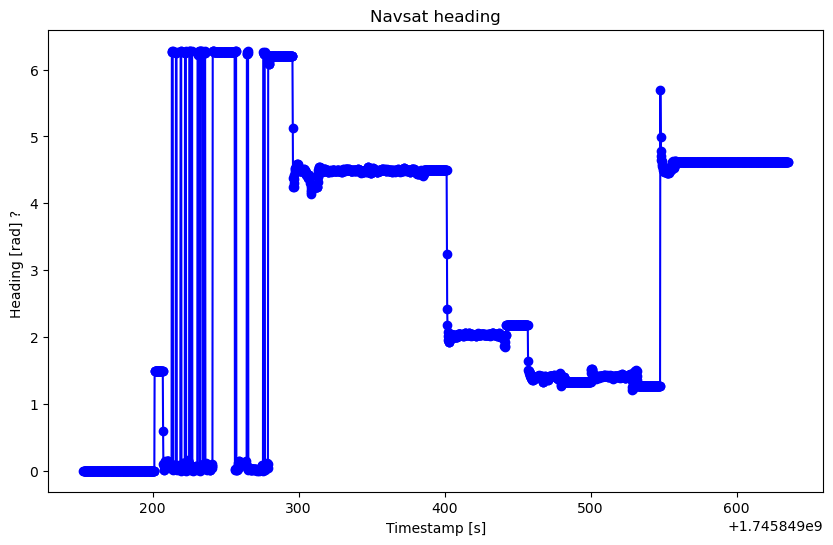

In [47]:
plot_navsat_heading_data_from_df(get_navsat_heading_df_from_db3_reader(db3_reader))

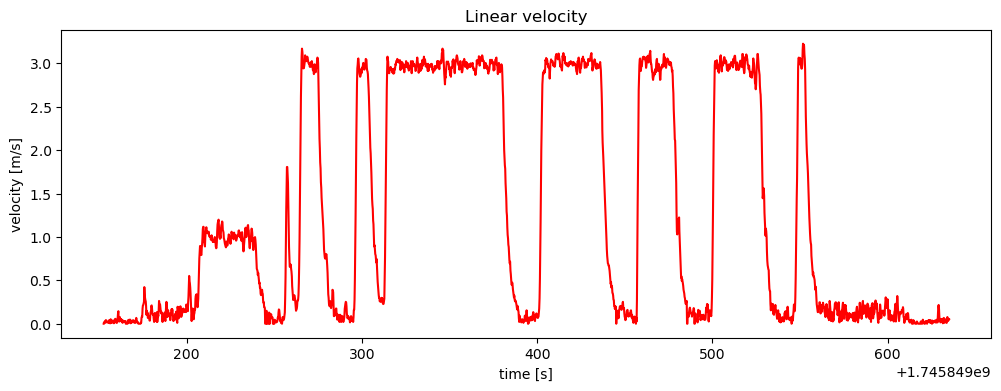

In [48]:
vel_df = get_velocity_df_from_db3_reader(db3_reader)
# plot_velocity_from_df(vel_df)

plot_speed_from_np(vel_df['timestamp_sample'], get_speed_from_navsat_velocity_df(vel_df))
plt.show()

In [49]:
speed_array = get_speed_from_navsat_velocity_df(vel_df)